# Tutorial 6 (Week 8) - Classification Analysis

## Learning Objectives

After completing this tutorial, you should be able to:

+ Understand model thresholding
+ Use sklearn to plot ROC curves in binary classification
+ Use sklearn to calculate AUROC
+ Use sklearn to plot ROC curves in multi-class classification

This tutorial is based on this [ROC and AUC tutorial](https://www.kaggle.com/code/jacoporepossi/tutorial-roc-auc-clearly-explained) and the Scikit-learn [ROC User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc).

## Table of Contents

* [Dataset](#Dataset)
* [Confusion Matrix](#Confusion-Matrix)
* [Model Thresholds](#Model-Thresholds)
* [Receiver Operating Characteristic (ROC)](#ROC)
* [Area Under the Curve (AUC or AUROC)](#AUROC)
* [ROC Curve Application -- Comparability](#Comparability)
* [AUROC Properties](#AUROC-Properties)
* [AUROC in Multi-Class Classification](#Multi-Class)

## Dataset <a class="anchor" id="Dataset"></a>

Let us first create a toy dataset for experimenting. The Scikit-learn `datasets` module has a handy function [`make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) to generate a random n-class classification problem. 

We create a dataset with 50 samples (with default number of features) and 2 classes, with 40:60 proportion of samples assigned to each class. We set the class separation to be 0.1, which is a factor determining how spread out the classes are (the larger the value, the more spread out and the easier the classification task is). 

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification

x, y = make_classification( n_classes = 2,
                            class_sep = 0.1,
                            n_samples = 50,
                            weights = [0.4, 0.6],
                            random_state = 42 )

# x contains the samples
print( x.shape )

# y contains the labels
print( y.shape )

(50, 20)
(50,)


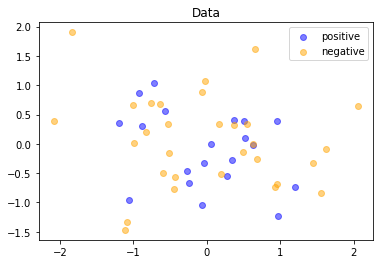

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Associate label value 0 (resp. 1) with the color blue (resp. orange) and label text 'positive' (resp. 'negative')
for c, i, t in zip( ['blue', 'orange'], [0, 1], ['positive', 'negative'] ):
    plt.scatter( x[y==i, 0], x[y==i, 1], color=c, alpha=.5, label=t )

plt.legend()
plt.title( 'Data' )
plt.show()

Next, we make a random prediction.

In [3]:
np.random.seed(42)

y_pred = np.random.choice([0, 1], size=(50))
y_pred

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1])

## Confusion Matrix <a class="anchor" id="Confusion-Matrix"></a>

Let's build the confusion matrix for our random prediction. We can use `sklearn.metrics.confusion_matrix` to get the raw counts as we have seen in Tutorial 4.

In [4]:
# TODO
# c = ?
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y, y_pred)
c

array([[14,  6],
       [ 9, 21]], dtype=int64)

We can then calculate the True Positive Rate (TPR) and False Positive Rate (FPR) from those counts.

In [5]:
# TODO
# tn, fp, fn, tp = ?
# tpr = ?
# fpr = ?
tn = c[0,0]
fp = c[0,1]
fn = c[1,0]
tp = c[1,1]
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

# tn,fp,fn,tp = c.ravel()

print( "TPR:", tpr )
print( "FPR:", fpr )

TPR: 0.7
FPR: 0.3


## Model Thresholds <a class="anchor" id="Model-Thresholds"></a>

The goal of classification is to predict a class label. However, many machine learning algorithms predict a probability or scoring of class membership, and we need to interpret this to map the prediction to a specific class label. This mapping is achieved using a _threshold_ (e.g., 0.5), where all predictions at or above the threshold are mapped to one class and all other values are mapped to another class.

In scikit-learn we can generally use two functions to perform prediction on new data: `predict` and `predict_proba`.

The `predict_proba` function returns a two-dimensional array (`n_samples` x `n_classes`), containing the estimated probabilities for each instance and each class. For example, a prediction for 4 samples with 2 possible classes (0 or 'positive', and 1 or 'negative') may look like this:

```
array( [[0.90, 0.10],
        [0.25, 0.75],
        [0.78, 0.22],
        [0.05, 0.95]])
```
This prediction says that the first sample has 90% probability of belonging to the positive class (and 10% probability of belonging to the negative class), the second sample has 75% probability of belonging to the negative class (and 25% probability of belonging to the positive class), and so on.

The `predict` function simply gives the class with the maximum probability. For the above example, it will return:

```
array( [0, 1, 0, 1] )
```

Using `predict_proba`, we can adjust how our model predicts a class or the other by varying the threshold. For instance, we can set threshold = 0.8 for the negative class, so that the model will predict the negative class only for samples that have probability >= 80% of belonging to the negative class. 

For the above example, the model will predict the second sample as the positive class instead of the negative class as previously, since it has only 75% (<80%) probability of belonging to the negative class.

Varying the thresholds will thus _affect TPR and FPR_.

## Receiver Operating Characteristic (ROC) <a class="anchor" id="ROC"></a>

ROC curves are typically used in _binary classification_ to study the output of a classifier. An ROC curve is built by plotting FPR on the X axis and TPR on the Y axis using different threshold values.

Let's test it with a simple model.

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit( x, y )

LogisticRegression()

We call `predict_proba()` and take the first column of the result, i.e., the probabilities of the samples belonging to the positive class.

In [7]:
y_score = model.predict_proba(x)[:,1]
y_score

array([0.3958005 , 0.467882  , 0.13702421, 0.36033886, 0.97468144,
       0.31741709, 0.12865663, 0.1341451 , 0.68652036, 0.45723294,
       0.42296672, 0.95088364, 0.3993275 , 0.81261241, 0.54575566,
       0.55121178, 0.30503177, 0.77271586, 0.58577112, 0.92816046,
       0.8540682 , 0.67354602, 0.26658869, 0.48982345, 0.92780298,
       0.68459755, 0.63726055, 0.45035582, 0.56526073, 0.87145707,
       0.40718843, 0.90632837, 0.44544938, 0.82647063, 0.59266956,
       0.04630259, 0.908385  , 0.90781113, 0.4941188 , 0.32176236,
       0.84331743, 0.98632413, 0.65307855, 0.8778805 , 0.86238492,
       0.79842378, 0.42379931, 0.08292369, 0.92315871, 0.93728311])

Now let's build the ROC curve, using the sklearn function [`roc_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) from the `metrics` module. We provide it with the true label and the predicted `y_score`, and it essentially:
- determines various threshold values, and
- calculates the FPR and TPR values for each threshold.

In [8]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve( y, y_score )

We can gather them in a DataFrame for ease of viewing.

In [9]:
roc_df = pd.DataFrame( zip(fpr, tpr, thresholds), columns = ["FPR", "TPR", "Threshold"])

print( roc_df.shape )
roc_df.head()

(20, 3)


,FPR,TPR,Threshold
0,0.00,0.000000,1.986324
1,0.00,0.033333,0.986324
2,0.00,0.533333,0.826471
3,0.05,0.533333,0.812612
4,0.05,0.600000,0.772716


As explained in the API reference, `thresholds[0]` represents no instances being predicted and is arbitrarily set to `np.inf`.

_Question to ponder: How do you think the `roc_curve()` function determines what threshold values to use?_

Let's now create the plot with FPR on the X axis and TPR on the Y axis.

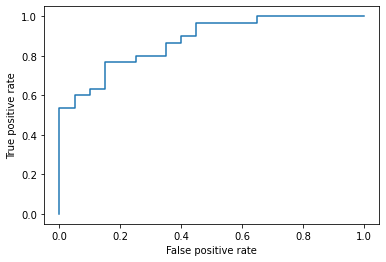

In [10]:
fig, ax = plt.subplots()

ax.plot( fpr, tpr )

ax.set_xlabel( 'False positive rate' )
ax.set_ylabel( 'True positive rate' )

plt.show()

The top left corner of the plot is the "ideal" point: FPR of zero and TPR of one.

## Area Under the Curve (AUC or AUROC) <a class="anchor" id="AUROC"></a>

The area underneath the entire ROC curve is called AUROC (or AUC) and is always represented as a value between 0 to 1.

We can see that the nearer the ROC curve is to the "ideal" point, the larger the area under the curve will be. Thus, we usually want to maximize AUROC, as this means achieving highest possible TPR and lowest possible FPR. 

_Question to ponder: Is it always the case?_

We can compute the AUROC using the sklearn function [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), giving it the prediction scores, similar to how we use `roc_curve()`. 

In [11]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score( y, y_score )
auroc

0.8766666666666667

We can redraw the ROC curve plot with the area filled.

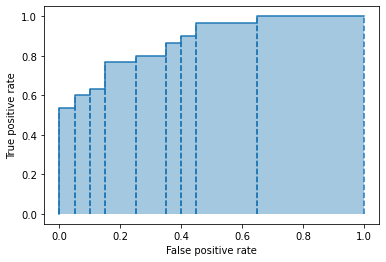

In [12]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr)

ax.fill_between( fpr, tpr, step="pre", alpha=0.4 )

ax.set_xlabel( 'False positive rate' )
ax.set_ylabel( 'True positive rate' )

# Project points to x-axis
plt.vlines( fpr, 0, tpr, linestyle="dashed" )

plt.show()

The dashed lines illustrate how the AUROC calculation is done -- the function basically calculates the area of each rectangle and sums them up.

## ROC Curve Application - Comparability <a class="anchor" id="Comparability"></a>

The ROC curve is valuable mainly for two reasons:

- It lets us select an optimal threshold for that model, and 
- It gives us a visual way to compare different classifiers.

Let's illustrate the second point by using another classifier together with the previous one.

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier( max_depth=1 )
rf.fit( x, y )

RandomForestClassifier(max_depth=1)

Following the same steps as the first classifier, perform the prediction, build the ROC curve, and compute the AUROC.

In [16]:
# TODO
# y_score_rf = ?
y_score_rf = rf.predict_proba(x)[:,1]
y_score_rf

array([0.50569042, 0.59829193, 0.53110061, 0.54175051, 0.65429404,
       0.56720033, 0.44503002, 0.52187612, 0.54205681, 0.60824939,
       0.64983014, 0.65767734, 0.62986322, 0.5877154 , 0.56249081,
       0.50960748, 0.43381159, 0.63552864, 0.63076833, 0.61966272,
       0.62517539, 0.56382494, 0.51570041, 0.59127854, 0.66151438,
       0.60709442, 0.62870044, 0.49349089, 0.49811241, 0.66188718,
       0.62831395, 0.640696  , 0.55466213, 0.63595481, 0.58314628,
       0.52686144, 0.64841261, 0.657799  , 0.53483702, 0.47460234,
       0.69894497, 0.74144123, 0.58256003, 0.67405195, 0.69098906,
       0.554764  , 0.5800224 , 0.49318345, 0.60427249, 0.67754342])

In [21]:
# TODO
# fpr_rf, tpr_rf, thresholds_rf = ?
fpr_rf, tpr_rf, thresholds_rf = roc_curve( y, y_score_rf)

In [22]:
# TODO
# auroc_rf = ?
auroc_rf = roc_auc_score( y, y_score_rf )
auroc_rf

0.9450000000000001

Now we can put them together, and also add the ROC curve of a hypothetical _perfect classifier_, i.e., one that will always have TPR = 1 regardless of the FPR. 

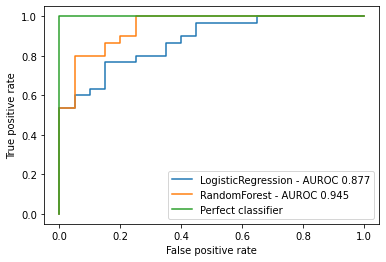

In [23]:
fig, ax = plt.subplots()

# Logistic Regression
ax.plot( fpr, tpr )

# Random Forest
ax.plot( fpr_rf, tpr_rf )

# Perfect Classifier
ax.plot([0, 0, 1], [0, 1, 1])

ax.set_xlabel( 'False positive rate' )
ax.set_ylabel( 'True positive rate' )
ax.legend(
    [
        'LogisticRegression - AUROC {:.3f}'.format(auroc),
        'RandomForest - AUROC {:.3f}'.format(auroc_rf),
        'Perfect classifier'
    ]
)

plt.show()

We can see that, compared to the LogisticRegression classifier, the RandomForest classifier has:
- higher ROC curve (closer to the perfect classifier), and
- larger AUROC value.

Therefore, we can say that the RandomForest classifier is doing a better job than the LogisticRegression classifier at classifying the positive class in the dataset.

## AUROC Properties <a class="anchor" id="AUROC-Properties"></a>

AUROC has the following properties that are desirable for measuring classification performance:

- Scale-invariant: It measures how well predictions are ranked, rather than their absolute values.
- Threshold-invariant: It measures the quality of the model's predictions irrespective of what classification threshold is chosen.


## AUROC in Multi-Class Classification <a class="anchor" id="Multi-Class"></a>

We have so far talked about binary classification. The `roc_auc_score` function can also be used in _multi-class classification_. Scikit-learn currently supports two averaging strategies:

- The __one-vs-one (OvO)__ algorithm computes the average of the pairwise AUROC scores.

- The __one-vs-rest (OvR)__ algorithm computes the average of the AUROC scores for each class against all other classes.

In both cases, the predicted labels are provided in an array with values from 0 to` n_classes`, and the scores correspond to the probability estimates that a sample belongs to a particular class. Both algorithms support weighting uniformly (`average='macro'`) and by prevalence (`average='weighted'`).

Let's illustrate using the iris dataset which we have seen in past tutorial.

In [43]:
from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

In [51]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

Let's shuffle and split it into training and test datasets.

In [52]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=0 )

For the purpose of this illustration, we use [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) with [`SVC`](https://scikit-learn.org/1.0/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) as the estimator to learn from the data.

In [58]:
random_state = np.random.RandomState(0)

classifier = OneVsRestClassifier(
    svm.SVC( kernel="linear", probability=True, random_state=random_state )
)
y_score = classifier.fit( X_train, y_train ).decision_function( X_test )
y_score[:10,0]

array([-3.58459897, -2.15411929,  1.89199335, -4.52609987,  1.39684192,
       -4.29544529,  1.60323992, -2.65028866, -2.86540149, -1.98461469])

We can now perform the prediction.

In [59]:
y_prob = classifier.predict_proba( X_test )
y_prob[:10,0]

array([3.16631734e-03, 3.89636466e-02, 9.79801886e-01, 6.04083469e-04,
       9.53082407e-01, 9.06479755e-04, 9.66883886e-01, 1.63680496e-02,
       1.12177857e-02, 5.22229800e-02])

Let's calculate the AUROC values for each of the algorithms, OvO and OvR, each with macro-averaging and weighted-averaging. 

In [55]:
macro_roc_auc_ovo = roc_auc_score( y_test, y_prob, multi_class="ovo", average="macro" )
weighted_roc_auc_ovo = roc_auc_score( y_test, y_prob, multi_class="ovo", average="weighted" )
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)

One-vs-One ROC AUC scores:
0.905527 (macro),
0.887024 (weighted by prevalence)


In [56]:
macro_roc_auc_ovr = roc_auc_score( y_test, y_prob, multi_class="ovr", average="macro" )
weighted_roc_auc_ovr = roc_auc_score( y_test, y_prob, multi_class="ovr", average="weighted" )
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-Rest ROC AUC scores:
0.905527 (macro),
0.887024 (weighted by prevalence)
